# Predicting Player Activity on a Minecraft Research Server


### Introduction


In this investigation, we will predict the total hours played by players according to the players.csv dataset. In the study led by Frank Wood, players’ actions and profiles were observed on a Minecraft server. One of the research's key challenges is predicting which types of players are likely to generate large amounts of gameplay data. This information would allow them to target recruitment more effectively and plan the necessary computing resources to operate the server. For the purpose of this report, we will see if the data describing each player in players.csv, which includes 196 observations and 7 variables: (experience, subscription, “hashedEmail,” played hours, name, gender, and age), can predict the total hours played by a player. Below is a summary of the players.csv data set:


|Variable Name | Type | Description |
|---|---|---|
| experience | character | Tells us the player's experience level: beginner, regular, amateur, veteran, or pro  |
|subscribe | logical | Whether the player subscribed to the newsletter (TRUE = subscribed, FALSE = not subscribed), there are 52 players not subscribed and 144 subscribed  |
|hashedemail | character | Encrypted player email identifier  |
|played_hours | numeric | Total number of hours the player has spent playing|
|name | character | Player's name|
| gender | character | Gives the player's gender|
| age | numeric | Player's age in years|


To begin exploring our question, we wanted to choose predictor variables based on those we inferred would have the most impact on predicting the total hours played. We selected gender, age, subscription status, and experience level. Gender and age capture basic demographic differences that may affect gaming habits. Subscription status reflects a player’s level of interest or engagement, which may relate to how much they play. Experience level indicates how comfortable a player is with the game, which can affect how long they stay active on the server. This narrowed down our question to: ***Can the variables of gender, age, subscription, and experience be used to predict the total hours played by a player?***

### Method & Results

##### Loading and Cleaning Data

In [31]:
# Loading Appropriate Packages 
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)

In [52]:
# Loading and Reading Data
players<- read_csv("data/players.csv")

# Wrangling and cleaning data
# 1. Converting categorical variables to factors

clean_players<- players|>
drop_na()|>
select(played_hours, gender, Age, subscribe, experience)|>
mutate(gender=as_factor(gender),
       experience=as_factor(experience),
       subscribe=as_factor(subscribe))|>
filter(played_hours > 0) |>
    mutate(age_group = cut(Age, breaks = c(5, 10, 15, 20, 25, 30, 35, 40, 45, 50, Inf), labels = c("5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50+")))


# Relevant summary of the Dataset
summary(clean_players)



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


  played_hours                  gender        Age       subscribe 
 Min.   :  0.10   Male             :75   Min.   : 9.0   FALSE:25  
 1st Qu.:  0.10   Female           :21   1st Qu.:17.0   TRUE :84  
 Median :  0.50   Non-binary       : 6   Median :20.0             
 Mean   : 10.51   Prefer not to say: 5   Mean   :21.3             
 3rd Qu.:  1.80   Agender          : 1   3rd Qu.:23.0             
 Max.   :223.10   Two-Spirited     : 1   Max.   :58.0             
                                                                  
    experience   age_group 
 Pro     :10   15-19  :51  
 Veteran :26   20-24  :35  
 Amateur :35   10-14  : 6  
 Regular :19   25-29  : 6  
 Beginner:19   5-9    : 2  
               30-34  : 2  
               (Other): 7  

#### Visuallization for Exploratory Dataset

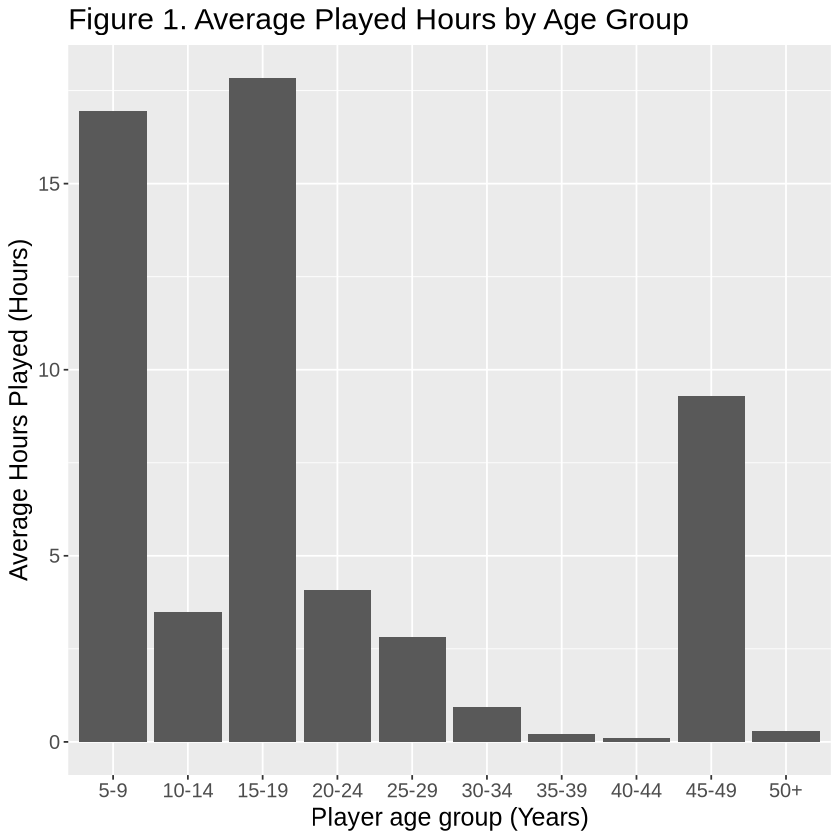

In [61]:
# Figure 1. Average Played Hours by Age Group

avg_hrs_played_by_age_group<- clean_players|>
group_by(age_group)|>
summarise(avg_played_hrs = mean(played_hours))

figure_1<- ggplot(avg_hrs_played_by_age_group, aes(x = age_group, y = avg_played_hrs))+
geom_bar(stat="identity")+
labs( title = "Figure 1. Average Played Hours by Age Group",
     x = "Player age group (Years)",
     y= "Average Hours Played (Hours)")+
        theme(text = element_text(size = 15))



figure_1


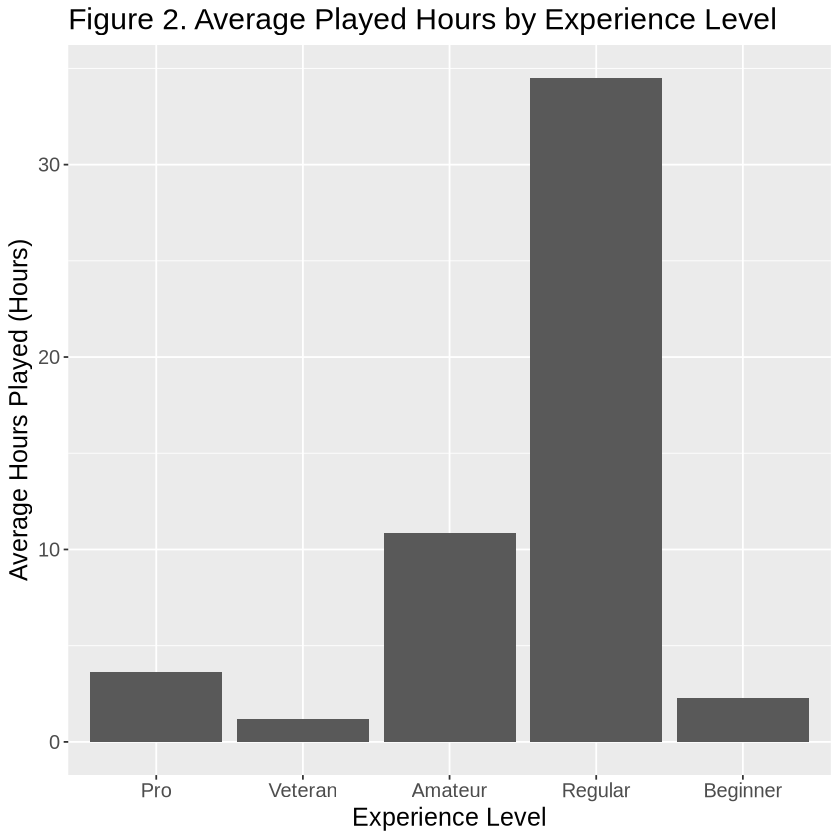

In [62]:
# Figure 2. Average Played Hours by Experience Level
avg_hours_experience <- clean_players |>
  group_by(experience) |>
  summarise(avg_hours = mean(played_hours))

figure_2 <- ggplot(avg_hours_experience,
                   aes(x = experience, y = avg_hours)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure 2. Average Played Hours by Experience Level",
    x = "Experience Level",
    y = "Average Hours Played (Hours)"
  ) +
  theme(text = element_text(size = 15))

figure_2


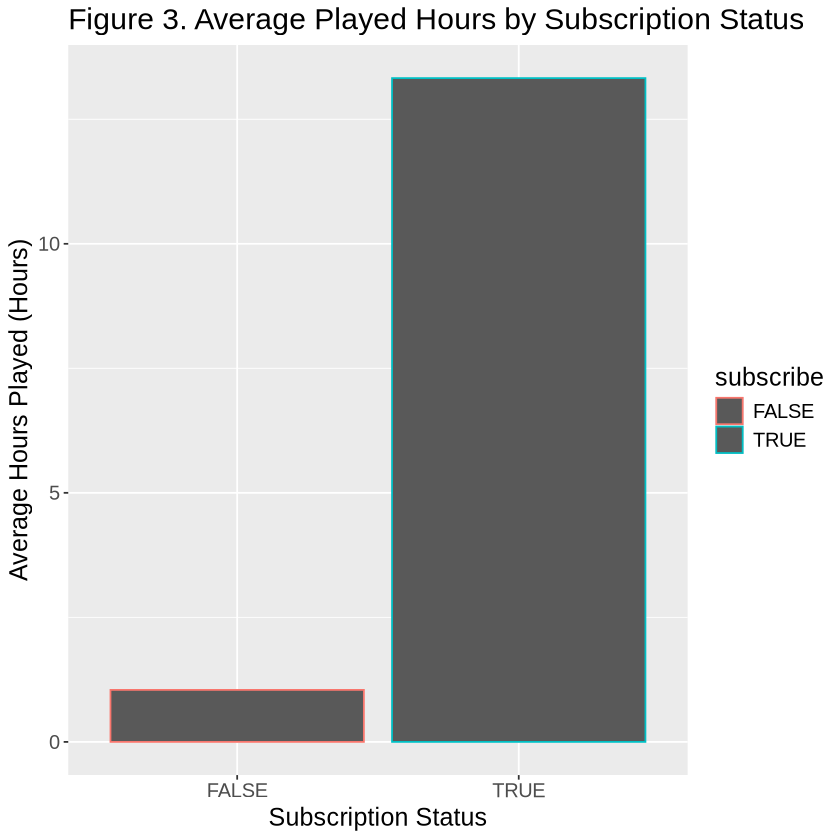

In [71]:
#Figure 3. Average Played Hours by Subscription Status
avg_hours_subscription <- clean_players |>
  group_by(subscribe) |>
  summarise(avg_hours = mean(played_hours))

figure_3 <- ggplot(avg_hours_subscription,
                   aes(x = subscribe, y = avg_hours, color= subscribe)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure 3. Average Played Hours by Subscription Status",
    x = "Subscription Status",
    y = "Average Hours Played (Hours)"
  ) +
  theme(text = element_text(size = 15))

figure_3


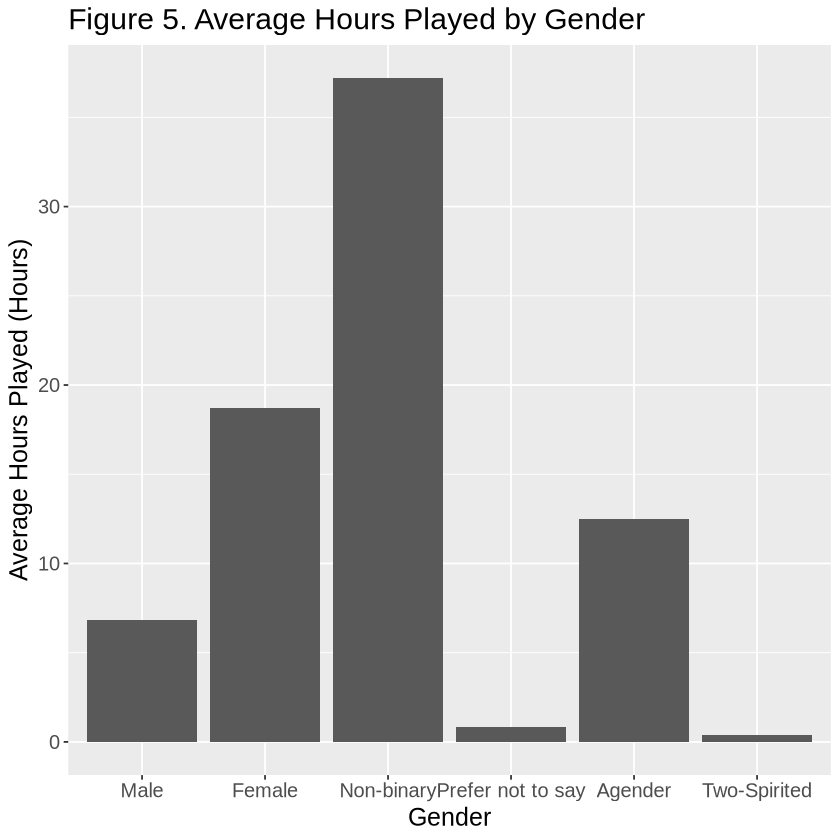

In [74]:
#Figure 4. Average Hours Played by Gender
avg_hours_gender <- clean_players |>
  group_by(gender) |>
  summarise(avg_hours = mean(played_hours))

figure_4 <- ggplot(avg_hours_gender,
                   aes(x = gender, y = avg_hours)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure 5. Average Hours Played by Gender",
    x = "Gender",
    y = "Average Hours Played (Hours)"
  ) +
  theme(text = element_text(size = 15))

figure_4


### Data Anaylsis

To determine whether gender, age, experience level, and subscription status can be used to predict the total hours played by a user on the Minecraft research server, we conducted a structured data-analysis workflow that follows 5 major steps: loading, cleaning, summarizing, visualizing and modelling. After loading the players.csv dataset into R using read_csv(), the dataset required cleaning to ensure each predictor was usable and properly formatted for modelling. This entailed: Converting categorical variables (gender, experience, subscribe) into factors. And creating an age_group variable by binning raw age values into interpretable ranges, to help identify demographic trends. 


Descriptive Summary
Played hours ranged from 0.1 to 223 hours.
Gender was predominantely male (75 respondants)
Age ranged from 9 to 58 years

Exploratory Visualizations

Figure 1. Average Played Hours by Age Group

This visualization reveals strong age-based differences. The 15-19 and 5-9 groups show the highest mean gameplay time, suggesting that adolescents and younger players tend to engage most with the server.

Figure 2. Average played hours by Experience Level

This visualizations demonstrates that the most involved players tend to be "Regulars" and "Amateurs". Most experienced players, those who logged on as "Veterans" amassed the least avg hours. 

Figure 3. Average played hours by subscription status

This chart shows a clear correlation between avg hours played and the subscription status of players. Players who were subscibers logged significantly longer avg hours than those who are unsubcribed.

Figure 5. Average played hours by gender


In this project, we construct a K-nearest neighbors (K-NN) regression model to predict the numerical response variable played_hours, which represents the total number of hours a player spent on the minecraft server. The predictor variables used in the model were: age, gender, subscription status, and experience level. These 4 predictors are stated in our research question, and visualized above. Each variable appeared to show meaningful variation with respect to played_hours. The choice of K-nearest neighbors regression allows all four predictors to jointly contribute to predicting how many hours a new player will play based on a new player's characterestics.




In [21]:
library(tidyverse)
library(tidymodels)






In [22]:
glimpse(players)






ERROR: Error in eval(expr, envir, enclos): object 'players' not found


In [23]:
players <- players |> 
  mutate(
    subscribe = as.factor(subscribe),
    gender = as.factor(gender),
    experience = as.factor(experience)
  )



ERROR: Error in eval(expr, envir, enclos): object 'players' not found


In [24]:
set.seed(123)
data_split <- initial_split(players, prop = 0.75)
train_data <- training(data_split)
test_data  <- testing(data_split)



ERROR: Error in eval(expr, envir, enclos): object 'players' not found


In [25]:
reg_recipe <- recipe(played_hours ~ age + gender + subscribe + experience,
                     data = train_data) |>
  step_dummy(all_nominal_predictors()) |>
  step_center(all_numeric_predictors()) |>
  step_scale(all_numeric_predictors())



ERROR: Error in eval(expr, envir, enclos): object 'train_data' not found


In [26]:
lin_mod <- linear_reg() |>
  set_engine("lm")


In [27]:
reg_workflow <- workflow() |>
  add_recipe(reg_recipe) |>
  add_model(lin_mod)



ERROR: Error in eval(expr, envir, enclos): object 'reg_recipe' not found


In [28]:
reg_fit <- reg_workflow |>
  fit(data = train_data)


ERROR: Error in eval(expr, envir, enclos): object 'reg_workflow' not found


In [29]:
reg_fit |> tidy()



ERROR: Error in eval(expr, envir, enclos): object 'reg_fit' not found


In [30]:
test_results <- reg_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = played_hours, estimate = .pred)

test_results



ERROR: Error in eval(expr, envir, enclos): object 'reg_fit' not found


In [31]:
new_player <- tibble(
  age = 20,
  gender = "Male",
  subscribe = "TRUE",
  experience = "Pro"
)

predict(reg_fit, new_player)




ERROR: Error in eval(expr, envir, enclos): object 'reg_fit' not found


In [32]:
knn_final_model <- 
  nearest_neighbor(
    mode = "regression",
    neighbors = 55,      # ← YOUR CHOSEN K
    weight_func = "rectangular"
  ) |>
  set_engine("kknn")



In [33]:
library(tidyverse)
library(tidymodels)


In [34]:
glimpse(players)


ERROR: Error in eval(expr, envir, enclos): object 'players' not found


In [35]:
set.seed(123)

players_split <- initial_split(players, prop = 0.75)
players_train <- training(players_split)
players_test  <- testing(players_split)


ERROR: Error in eval(expr, envir, enclos): object 'players' not found


In [12]:
knn_recipe <- recipe(played_hours ~ age + gender + subscribe + experience,
                     data = players_train) %>%
  step_dummy(all_nominal_predictors()) %>%
  step_center(all_predictors()) %>%
  step_scale(all_predictors())


ERROR: Error in eval(expr, envir, enclos): object 'players_train' not found


In [13]:
knn_spec <- nearest_neighbor(
  mode = "regression",
  neighbors = 5,
  weight_func = "rectangular"
) %>%
  set_engine("kknn")


In [14]:
knn_workflow <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_spec)


ERROR: Error: object 'knn_recipe' not found


In [15]:
knn_grid <- grid_regular(neighbors(range = c(1, 200)), levels = 30)


In [16]:
set.seed(123)
players_folds <- vfold_cv(players_train, v = 5)


ERROR: Error in eval(expr, envir, enclos): object 'players_train' not found


In [17]:
knn_tune_results <- tune_grid(
  knn_workflow,
  resamples = players_folds,
  grid = knn_grid,
  metrics = metric_set(rmse, rsq, mae)
)


ERROR: Error in eval(expr, envir, enclos): object 'knn_workflow' not found


In [18]:
best_k <- select_best(knn_tune_results, "rmse")
best_k


ERROR: Error in eval(expr, envir, enclos): object 'knn_tune_results' not found


In [19]:
final_knn_fit <- fit(final_knn_workflow, data = players_train)

ERROR: Error in eval(expr, envir, enclos): object 'final_knn_workflow' not found


In [20]:
players_test_clean <- players_test %>%
  drop_na(age, gender, subscribe, experience, played_hours)

knn_predictions <- predict(final_knn_fit, players_test_clean) %>%
  bind_cols(players_test_clean)

metrics <- knn_predictions %>%
  metrics(truth = played_hours, estimate = .pred)

metrics



ERROR: Error in eval(expr, envir, enclos): object 'players_test' not found
